# **Predicting the quality of red wine from pH, alcohol, residual sugar and sulphates.**

Group members: Czesia Lindsay, Kelly Nguyen, Persa Shameyl, Maddie Wright

### **Introduction**

Red wine is an alcoholic drink with varying properties that depend on the fermentation process and varieties of grape used to create it (Watrelot et al., 2019). The large variety translate into providing a vast range of quality for red wines. 

This report will determine if the quality of red variants of the Portuguese "Vinho Verde" wine, can be accurately predicted using pH, alcohol (vol%), residual sugar (g/dm^3) and sulphates (g/dm^3). The dataset used to further investigate has 11 variables of over 1500 red wine samples with the quality score it was given. The score is a range from 0-10, where a score >6.5 is considered good quality, a score <5 is consider lower quality while the values inbetween are decent quality. To maximize the reach of this project; pH, alcohol, residual sugar and sulphates were chosen as the predictive variables they are the aspects of wine most casual wine drinkers would likely be familiar with.

In [1]:
#code packages
library(tidyverse)
library(repr)
library(cowplot)
library(scales)
library(GGally)
library(ggplot2)
library(tidymodels)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
“package ‘cowplot’ was built under R version 4.3.2”

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Warning message:
“package ‘GGally’ was built under R version 4.3.2

In [2]:
url <- "https://raw.githubusercontent.com/swallowmesea/37/main/data/winequality-red.csv"
download.file(url, 'data/winequality-red.csv')
red_wine <- read_delim('data/winequality-red.csv', delim = ';')
red_wine <- red_wine |>
mutate(quality = as_factor(quality))
colnames(red_wine) <- c("fixed_acidity","volatile_acidity","citric_acid","residual_sugar", "chlorides",
"free_sulfur_dioxide", "total_sulfur_dioxide", "density", "pH", "sulphates", "alcohol", "quality")


#general training data
set.seed(2222)
wine_split <- initial_split(red_wine, prop = 0.75, strata = quality)
wine_train <- training(wine_split)
wine_test <- testing(wine_split)
head(wine_train)

Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5
7.5,0.50,0.36,6.1,0.071,17,102,0.9978,3.35,0.80,10.5,5
6.7,0.58,0.08,1.8,0.097,15,65,0.9959,3.28,0.54,9.2,5


### Summary

In [3]:
quality_obs <- wine_train |>
group_by(quality) |>
summarize(n = n()) |>
mutate(percentage = 100*n/nrow(wine_train))
quality_obs

quality,n,percentage
<fct>,<int>,<dbl>
3,9,0.7518797
4,39,3.2581454
5,508,42.4394319
6,478,39.9331662
7,150,12.5313283
8,13,1.0860485


In [4]:
sugar_summary <- wine_train |>
group_by(quality) |>
summarize(mean_sugar = mean(residual_sugar), median_sugar = median(residual_sugar), 
          min_sugar = min(residual_sugar), max_sugar = max(residual_sugar))
sugar_summary

quality,mean_sugar,median_sugar,min_sugar,max_sugar
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
3,2.683333,2.1,1.2,5.7
4,2.441026,2.1,1.4,5.6
5,2.541831,2.2,1.2,13.8
6,2.499059,2.2,0.9,15.4
7,2.732000,2.3,1.2,8.9
8,2.869231,2.5,1.4,6.4


In [5]:
pH_summary <- wine_train |>
group_by(quality) |>
summarize(mean_pH = mean(pH), median_pH = median(pH), 
          min_pH = min(pH), max_pH = max(pH))
pH_summary

quality,mean_pH,median_pH,min_pH,max_pH
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
3,3.414444,3.400,3.16,3.63
4,3.370256,3.370,2.74,3.75
5,3.302461,3.300,2.89,3.74
6,3.320439,3.320,2.86,4.01
7,3.298133,3.295,2.92,3.78
8,3.213077,3.210,2.88,3.56


In [6]:
alc_summary <- wine_train |>
group_by(quality) |>
summarize(mean_alcohol = mean(alcohol), median_alcohol = median(alcohol), 
          min_alcohol = min(alcohol), max_alcohol = max(alcohol))
alc_summary 

quality,mean_alcohol,median_alcohol,min_alcohol,max_alcohol
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
3,10.061111,9.95,8.4,11.0
4,10.233333,10.00,9.0,11.8
5,9.893504,9.70,8.5,13.0
6,10.638006,10.50,8.4,14.0
7,11.484000,11.55,9.5,14.0
8,12.046154,12.50,9.8,13.4


In [7]:
sulphates_summary <- wine_train |>
group_by(quality) |>
summarize(mean_sulphates = mean(sulphates), median_sulphates = median(sulphates), 
          min_sulphates = min(sulphates), max_sulphates = max(sulphates))
sulphates_summary

quality,mean_sulphates,median_sulphates,min_sulphates,max_sulphates
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
3,0.5700000,0.54,0.40,0.86
4,0.5956410,0.55,0.33,2.00
5,0.6227165,0.58,0.39,1.62
6,0.6799582,0.65,0.40,1.95
7,0.7393333,0.74,0.39,1.36
8,0.7515385,0.74,0.63,0.92


### **Visualization**

Using ggpairs the area graphs and boxplots can provide analytics showing mid-range to higher wine quality is dominated by the four predictor variables chosen: residual sugar, pH, sulphates and alcohol. These visualizations provide insight on what variables should be chosen to assist in furthering the classification algorithm for the wanted quality outcome. Furthermore, we may need to explore how the other 7 variables relate to the prediction of wine quality.

In [10]:
set.seed(3005)
options(repr.plot.width = 14, repr.plot.height = 8)
# ggpairs(wine_train,  
#         columns = c(1:12),
#         ggplot2::aes(color = quality, alpha = 0.5),
#         legend = 1,
#         upper = list(continuous = wrap("cor", size = 5)),
#         lower = list(combo = wrap('facethist', binwidth = 0.5)),
#         labs(fill = "quality")) + 
#     ggtitle("Relationship between all Predictor Variables") +
#     theme(title = element_text(size = 10)) +
#     theme_grey(base_size = 10)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


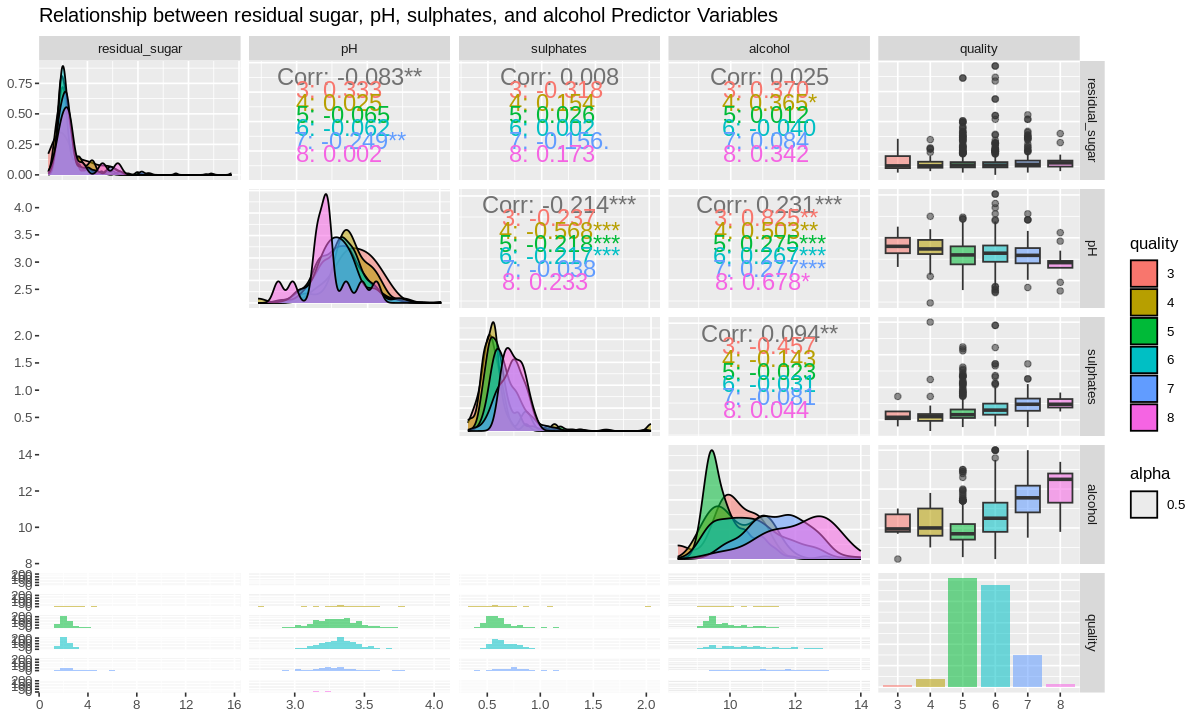

In [9]:
set.seed(3005)
options(repr.plot.width = 10, repr.plot.height = 6)
ggpairs(wine_train, 
        columns = c(4,9:12), 
        ggplot2::aes(color = quality, alpha = 0.5),
        legend = 1,
        upper = list(continuous = wrap("cor", size = 5)),
        lower = list(continuous = wrap('facethist', binwidth = 0.5)),
        labs(fill = "quality")) + 
    ggtitle("Relationship between residual sugar, pH, sulphates, and alcohol Predictor Variables") +
    theme(title = element_text(size = 10)) +
    theme_grey(base_size = 10)

In [16]:
wine_recipe <- recipe(quality ~ pH + alcohol + residual_sugar + sulphates, data = wine_train) |>
step_scale(all_predictors()) |>
step_center(all_predictors())
#wine_recipe

wine_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 5) |>
set_engine('kknn') |>
set_mode('classification')


wine_fit <- workflow() |>
add_recipe(wine_recipe) |>
add_model(wine_spec)|>
fit(data = wine_train)

wine_predict <- predict(wine_fit, wine_test) |>
bind_cols(wine_test)
head(wine_predict)

.pred_class,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
5,7.9,0.60,0.06,1.6,0.069,15,59,0.9964,3.30,0.46,9.4,5
6,8.9,0.62,0.18,3.8,0.176,52,145,0.9986,3.16,0.88,9.2,5
5,7.4,0.59,0.08,4.4,0.086,6,29,0.9974,3.38,0.50,9.0,4
5,7.9,0.32,0.51,1.8,0.341,17,56,0.9969,3.04,1.08,9.2,6
5,7.9,0.43,0.21,1.6,0.106,10,37,0.9966,3.17,0.91,9.5,5


In [15]:
wine_accuracy <- wine_predict |>
metrics(truth = quality, estimate = .pred_class)
wine_accuracy

wine_mat <- wine_predict |>
conf_mat(truth = quality, estimate = .pred_class)
wine_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5746269
kap,multiclass,0.3104700


          Truth
Prediction   3   4   5   6   7   8
         3   0   0   0   0   0   0
         4   0   1   3   1   0   0
         5   1   7 127  60   6   1
         6   0   5  39  86  26   1
         7   0   1   3  12  17   3
         8   0   0   1   1   0   0

### **Methods**


The data analysis will be conducted using a classification model and the K-nearest neighbors (knn) algorithm to predict the quality of red wine based on the 4 out of 11 chosen variables. 

The data will be standardized, then split the dataset into training and testing sets. The classifier will then be trained with the training set to learn the relationship between our predicting variables and our classifying variable (quality), then the performance of the trained model will be evaluated using the testing data to determine accuracy. The parameters may be fine-tuned to enhance the performance if needed.

Afterwards, the results will be visualized by creating scatter plots of each variable against another. The data points will colour code based on the predicted quality by the classifier. This visualization will help us understand how each feature relates to red wine quali

### **Expected Outcome and Significance**


The classification model is anticipated to achieve a satisfactory level of accuracy. It is expected that the chosen variables will exhibit a strong correlation with red wine quality in our dataset. Through visualizations, we expect to observe clear patterns and trends between the selected attributes with wine quality.

The findings from our analysis could have significant implications for the wine industry, particularly in quality assurance and control during wine production. Consumers often rely on quality indicators when selecting wines and these findings could provide valuable guidance to consumers by highlighting the key attributes associated with high-quality red wines (Basalekou, et al., 2023). This could then lead to improved overall satisfaction among consumers. The results of this project could also be used in further research to explore if the chosen predictors are equally important for predicting quality in other wine varieties.

##### **Future questions**

What effect do additional variables like acidity, tannin content, or grape varietal have on the estimation of wine quality?

Do identified predictors hold consistent predictive power across diverse wine types.?

How can we track the evolution of wine quality over time, including the aging process, and how this affects the relationship between key attributes and wine quality? .

### **References (APA format)**

Watrelot, A. A., Heymann, H., & Waterhouse, A. L. (2019). Red wine dryness perception related to physicochemistry. Journal of Agricultural and Food Chemistry, 68(10), 2964–2972. https://doi.org/10.1021/acs.jafc.9b01480  

Cortez,Paulo, Cerdeira,A., Almeida,F., Matos,T., and Reis,J.. (2009). Wine Quality. UCI Machine Learning Repository. https://doi.org/10.24432/C56S3T.

Basalekou, M., Tataridis, P., Georgakis, K., & Tsintonis, C. (2023). Measuring Wine Quality and Typicity. Beverages, 9, 41. https://doi.org/10.3390/beverages9020041